### АНСАМБЛИ МОДЕЛЕЙ

Загружаем библиотеки

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [121]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression
from math import sqrt

## Загрузка данных

In [122]:
#Загружаем обучающую и выборку, по которой будем строить предсказания для соревнования
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [123]:
from sklearn.model_selection import StratifiedShuffleSplit

In [125]:
#Отделяем целевую переменную и удаляем ее из выборки
Y = data.SalePrice
data.drop('SalePrice', axis=1, inplace=True)

## Первичный анализ

Размер датасета

In [7]:
data.shape

(1460, 80)

In [126]:
#Добавляем к выборкам столбец is_test, по которому будем отличать тренеровочные данных от данных, 
#для которых нужно предсказать цену

tr=data
te=data_test

tr['is_test'] = 0
te['is_test'] = 1

In [127]:
#Соединяем две выборки
df = pd.concat([tr, te])

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [128]:
cat_feat = list(df.dtypes[df.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
df[cat_feat] = df[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in df if f not in (cat_feat + ['ID', 'is_test'])]

cat_nunique = df[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

MSZoning          6
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType         10
SaleCondition     6
dtype: int64


In [129]:
#Разделяем выборки на ту, по которой будем учиться и ту, на которой будем предсказывать на основе ранее созданного столбца
d_train = df[df.is_test==0].drop('is_test', axis=1)
d_test = df[df.is_test==1].drop('is_test', axis=1)

## Композиции моделей одного семейства

### Будем использовать решающие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> отличный выбор для построения композиций

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
3. Создаем дамми-переменные для категорий

In [130]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)
dummy_train.shape

(1460, 268)

In [131]:
dummy_test.shape

(1459, 256)

In [132]:
dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [133]:
X_train.shape

(1460, 286)

In [134]:
X_test.shape

(1459, 286)

### Обучаем решающее дерево

Немного ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [135]:
from sklearn.tree import DecisionTreeRegressor

clf_tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, Y)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### Считаем RMSD

Делаем предсказания

In [137]:
y_pred_train = clf_tree.predict(X_train)

In [138]:
#Короткая функция для вывод RMSD
def met_cl (y_train, y_tr_pred):
    print('RMSD:', sqrt(mean_squared_log_error(y_train, y_tr_pred)))

In [139]:
#Функция для формирования сабмита на Kaggle
def create_submit (clf, X, fileName):
    #Делаем предсказания
    predictions = clf.predict(X)
    #Формируем строку
    submussion = 'Id,SalePrice\n'
    submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(data_test.Id, predictions)])
    #Записываем данные в файл
    with open(fileName, 'w') as file:
        file.write(submussion)

In [140]:
#Считаем RMSD для дерева
met_cl(Y, y_pred_train)

RMSD: 0.15425210236884798


In [141]:
#Формируем сабмит
create_submit(clf_tree, X_test, 'submission_tree.txt')

### Случайный лес

Бэггинг + случайные подпространства = случайный лес

**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [142]:
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=20, max_features=0.6, n_jobs=-1)

clf_rf.fit(X_train, Y)    

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [143]:
y_pred_rf_train = clf_rf.predict(X_train)

In [144]:
#Считаем RMSD для случайного леса
met_cl(Y, y_pred_rf_train)

RMSD: 0.1429955608266036


In [145]:
#Формируем сабмит на основе случайного леса для Kaggle
create_submit(clf_rf, X_test, 'submission_rf.txt')

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

In [52]:
#Выводим важности атрибутов
imp = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
imp2 = imp.sort_values(ascending=False).head(25)

In [53]:
imp2

OverallQual          0.476274
GarageCars           0.127953
GrLivArea            0.123678
ExterQual_TA         0.041939
TotalBsmtSF          0.040239
1stFlrSF             0.028971
BsmtFinSF1           0.023413
YearBuilt            0.023304
GarageArea           0.021395
BsmtQual_Ex          0.011426
LotArea              0.010779
FullBath             0.010115
TotRmsAbvGrd         0.007390
2ndFlrSF             0.005874
KitchenQual_Ex       0.004348
Fireplaces           0.003763
FireplaceQu_nan      0.003515
YearRemodAdd         0.003293
ExterQual_Gd         0.002994
GarageYrBlt          0.002904
MasVnrArea           0.002188
GarageType_Attchd    0.001761
CentralAir_N         0.001589
OpenPorchSF          0.001545
GarageType_Detchd    0.001400
dtype: float64

Явно видно, что одна фича значительно выделяется среди всех остальных - это OverallQual. 
На втором и третьем месте тоже достаточно важные фичи, хотя они и в 4 раза менее значимы первой, но совместо с ней они дают
более 0.72

# Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и к-ближайших соседей

**Преобразуем признаки**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаем дамми-переменные для категорий
4. Нормируем признаки

In [146]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

In [147]:
X_train_lin.shape

(1460, 366)

### Обучим линейную регрессию

In [148]:
from sklearn.linear_model import LinearRegression

In [149]:
clf_lr = LinearRegression()

clf_lr.fit(X_train_lin, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
y_pred_lin_train = clf_lr.predict(X_train_lin)

In [60]:
met_cl(Y, y_pred_lin_train)

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**!!! Не понятно почему не получается посчитать RMSD для линейной регрессии**

### Обучим knn

In [151]:
from sklearn.neighbors import KNeighborsRegressor

In [152]:
clf_knn = KNeighborsRegressor()

In [153]:
clf_knn.fit( X_train_lin, Y )

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [154]:
y_pred_knn_train = clf_knn.predict(X_train_lin)

In [156]:
#Посчитаем RMSD
met_cl(Y, y_pred_knn_train)

RMSD: 0.14171916173658144


In [157]:
#Сделаем сабмит модели построенной по knn для kaggle
create_submit(clf_rf, X_test, 'submission_knn.txt')

### Обучим bagging

In [158]:
from sklearn.ensemble import BaggingRegressor

In [159]:
clf_br = BaggingRegressor()

In [160]:
clf_br.fit( X_train_lin, Y )

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [161]:
y_pred_br_train = clf_br.predict(X_train_lin)

In [162]:
#Посчитаем RMSD
met_cl(Y, y_pred_br_train)

RMSD: 0.06846575282079398


In [163]:
#Сделаем сабмит для kaggle
create_submit(clf_rf, X_test, 'submission_br.txt')

### Построим линейную комбинацию knn и случайного леса

Будем строить линейную комбинацию вида

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

[ 0.]


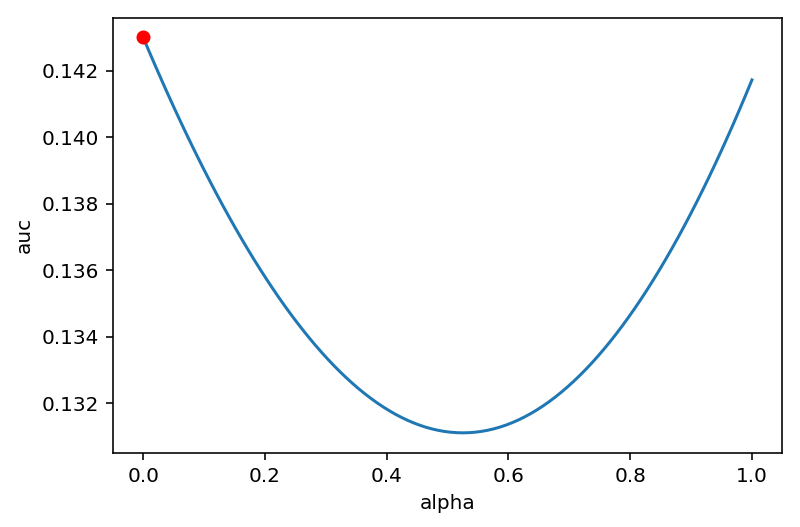

In [164]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_knn_train + (1 - alpha) * y_pred_rf_train
    aucs.append(sqrt(mean_squared_log_error(Y, y_pred_weight)))
aucs = np.array(aucs)    

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]
print(alpha)
plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_knn_train + (1 - alpha) * y_pred_rf_train

### Формируем сабмит из взвешенных предсказаний для kaggle

In [165]:
#Формируем строку
submussion = 'Id,SalePrice\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(data_test.Id, y_pred_weight)])
#Записываем данные в файл
with open('submussion_lk.txt', 'w') as file:
    file.write(submussion)

### Сравним 4 метода (посчитаем RMSD)

In [166]:
print('Weighted:')
met_cl(Y, y_pred_train)
print('KNN:')
met_cl(Y, y_pred_knn_train)
print('Bagging regression:')
met_cl(Y, y_pred_br_train)
print('Random forest:')
met_cl(Y, y_pred_rf_train)


Weighted:
RMSD: 0.15425210236884798
KNN:
RMSD: 0.14171916173658144
Bagging regression:
RMSD: 0.06846575282079398
Random forest:
RMSD: 0.1429955608266036


### Стэкинг

#### Средние значения таргета

Создадим новые признаки, на основе категориальных переменных. Каждому уникальному значению $V$ переменной $X_i$ сопоставим среднее значение таргета среди всех объектов, у которых переменная $X_i$ принимает значение $V$ 

Новый признак со средними значением таргета в категории можно считать за предсказание вер-ти класса 1 простого классификатора "усреднения"

Опишем класс этого классификатора

In [78]:
class MeanClassifier():
    def __init__(self, col):
        self._col = col
        
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()

    def predict(self, X):
        new_feature = X[self._col].astype(str)\
            .map(self._means.to_dict())\
            .fillna(self._y_mean)
        return new_feature

Делаем предсказания по фолдам кросс-валидации. **Главное не допустить утечки информации!**

Опишем функцию для стекинга

In [109]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

### Стекинг нескольких моделей
0. Средние значения
1. KNN
2. Bagging regression
3. Random Forest

In [110]:
y_test = y_pred_train

In [113]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=5, random_state=555)

meta_train = []
meta_test = []
col_names = []


print('mean features...')

for c in cat_nunique.index.tolist():
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, Y, d_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('mean_pred_{}'.format(c))


print('BR features...')
meta_tr = get_meta_features(clf_br, X_train_lin, Y, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('br_pred')

print('KNN features...')
meta_tr = get_meta_features(clf_knn, X_train_lin, Y, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knn_pred')

print('RF features...')
meta_tr = get_meta_features(clf_rf, X_train, Y, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('Finish')

mean features...


C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyError: 'MSZoning'

In [101]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стэкинг мета-признаков с помощью Random Forest

Используем случайный лес в качестве алгоритма второго уровня

In [102]:
clf_rf_meta = RandomForestRegressor()

clf_rf_meta.fit(X_meta_train, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [103]:
y_pred_meta_train = clf_rf_meta.predict(X_meta_train)
y_pred_meta_test = clf_rf_meta.predict(X_meta_test)

In [105]:
met_cl(Y, y_pred_meta_train)

RMSD: 0.06263032802225703


In [106]:
create_submit(clf_lr_meta, X_test, 'submission_ens.txt')

ValueError: Number of features of the model must match the input. Model n_features is 46 and input n_features is 286 

#### Посмотрим на коэффициенты объединяющей линейной модели

Получим интерпретацию общей модели

In [473]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

# Домашняя работа

#### Простая
1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

#### Средняя
0. Все то же, что и в части 1, плюс:
1. Попробовать другие оценки важности переменных, например Boruta
http://danielhomola.com/2015/05/08/borutapy-an-all-relevant-feature-selection-method/#comments
3. Изучить extremely randomized trees (ExtraTreesRegressor в sklearn), сравнить с Random Forest
4. Проводить настройку гиперпараметров для моделей первого уровня в стекинге (перебирать руками и смотреть на CV или по сетке: GridSearchCV, RandomizedSearchCV)
5. Попробовать другие алгоритмы второго уровня
6. Сделать сабмиты на kaggle (минимум 3: отдельные модели vs стекинг), сравнить качество на локальной валидации и на leaderboard
7. В качестве решения:
    * Jupyter notebook с кодом, комментариями и графиками
    * сабмит на kaggle (ник на leaderboard)